In [37]:
from argparse import ArgumentParser, FileType
from dataclasses import dataclass
from distutils.util import strtobool
import csv
from csv import DictReader
import numpy as np
import pandas as pd
import os
from typing import Optional

from matplotlib import pyplot as plt
import seaborn as sns

In [16]:
scored_predictions = pd.read_csv("../data/2021_annual.csv")

def parse_credence(c): return float(c[:-1]) / 100 if len(c) > 0 else np.nan

scored_predictions["Credence"] = scored_predictions["Credence"].map(parse_credence)
resolved_scored_predictions = scored_predictions[~scored_predictions["Resolution"].isna()]
resolved_scored_predictions

,Prediction,Credence,Category,Resolution,Source
0,Another baby born from an embryo publicly decl...,0.0300,Science,False,NaN
1,Proof that $ \rm{P} = \rm{NP} $ (confirmed by ...,0.0001,Science,False,NaN
2,Proof that $ \rm{P} \neq \rm{NP} $ (confirmed ...,0.0050,Science,False,NaN
3,Language model released that uses 10x the # of...,0.4000,Science,False,NaN
4,Highest exact match rate on SQuAD 2.0 $ >92.0 ...,0.6000,Science,False,NaN
6,Waymo self-driving car service open to the pub...,0.2000,Tech,False,NaN
7,Another company's self-driving car service ope...,0.1000,Tech,False,NaN
8,SpaceX starship has a successful test launch i...,0.6000,Tech,True,NaN
9,First Tesla Cybertruck delivered to customer i...,0.4500,Tech,False,NaN
10,Top price performance (in G3D Mark / \\$) of G...,0.5500,Tech,False,NaN


In [25]:
def get_log_score(credences, resolutions): 
    return np.mean(- (1-resolutions) * np.log(1-credences) - resolutions * np.log(credences))

def get_brier_score(credences, resolutions):
    residuals = (credences - resolutions)
    return np.mean(residuals ** 2) 

In [26]:
resolutions = resolved_scored_predictions["Resolution"].astype('int').values
credences = resolved_scored_predictions["Credence"].values

In [27]:
get_brier_score(credences, resolutions)

0.17867833355555554

In [28]:
get_log_score(credences, resolutions)

0.5380344515791861

In [72]:
categories = resolved_scored_predictions.Category.unique()
category_brier_scores = []
category_log_scores = []
for category in categories:
    resolved_scored_predictions_category = resolved_scored_predictions.query(f"Category == '{category}'")
    assert len(resolved_scored_predictions_category) > 0, category
    category_resolutions = resolved_scored_predictions_category["Resolution"].astype('int').values
    category_credences = resolved_scored_predictions_category["Credence"].values
    category_brier_scores.append(get_brier_score(category_credences, category_resolutions))
    category_log_scores.append(get_log_score(category_credences, category_resolutions))

Text(0.5, 1.0, 'Brier Scores by Category')

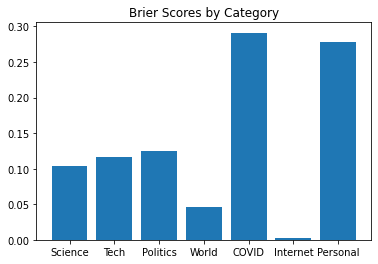

In [78]:
plt.bar(x=categories, height=category_brier_scores)
plt.title("Brier Scores by Category")

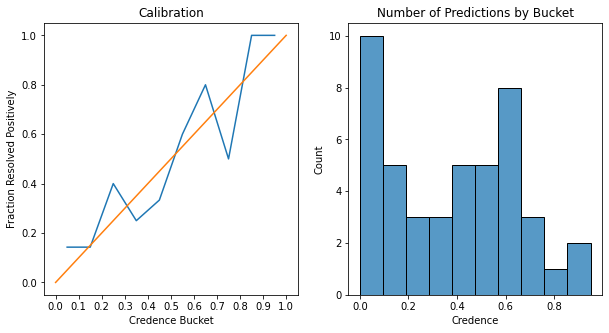

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
bin_size = 0.1
bins = np.arange(0, 1.1, bin_size)
fractions = []
for i, b in enumerate(bins[:-1]):
    nb = bins[i+1]
    df = resolved_scored_predictions[
        (resolved_scored_predictions['Credence'] >= b) &
        (resolved_scored_predictions['Credence'] <= nb)
    ]
    fractions.append(df['Resolution'].sum() / len(df))
axs[0].plot(bins[:-1] + bin_size / 2, fractions)
axs[0].plot([0, 1], [0, 1])
axs[0].set_xlabel("Credence Bucket")
axs[0].set_ylabel("Fraction Resolved Positively")
axs[0].set_xticks(bins)
axs[0].set_title("Calibration")
sns.histplot(resolved_scored_predictions['Credence'], ax=axs[1], bins=10)
axs[1].set_title("Number of Predictions by Bucket");
plt.savefig("../figures/2021_calibration_plot.png", facecolor="white", transparent=False)

In [66]:
bins[:-1] + bin_size / 2

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [52]:
bins[1:] - bins[:-1], bins

(array([0.2, 0.2, 0.2, 0.2, 0.2]), array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]))